# Capstone Project
### Exploring the relationship between housing prices in Toronto and venues available in the neighborhood

## Part 1 - Preparing the Dataset

In [1]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
!pip install xlrd

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 103 kB 3.5 MB/s eta 0:00:01


In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geographiclib-1.50   | 34 KB     | ##################################### | 100% 
g

### Import housing data & clean the data

Dataset source: https://github.com/slavaspirin/Toronto-housing-price-prediction/blob/master/

In [73]:
houses = pd.read_excel('data.xlsx', index_col=0)

In [74]:
#remove columns that are not needed
houses.drop(['title','description','mls','full_link'], axis=1, inplace=True)

In [75]:
#remove condos to focus only on houses
index = houses['type'].str.contains('Condo')
houses = houses[~index]
houses.shape

(7517, 11)

In [76]:
#clean row data
houses['final_price'] = houses.final_price.astype('str').str.replace(',','')
houses['list_price'] = houses.list_price.astype('str').str.replace(',','')
houses['list_price'] = houses.list_price.astype('str').str.replace('$','')
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
1,885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Semi-Detached,"2 Cabot Crt, Toronto",NaN,NaN,NaN
4,825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Detached,"61 Twelfth St, Toronto",NaN,NaN,NaN
6,2700000,2798000,4 beds,5 baths,2500–3000 sq. ft.,2 parking,Detached,"110 Albertus Ave, Toronto",NaN,NaN,NaN
8,975000,954900,2 beds,2 baths,1100–1500 sq. ft.,1 parking,Duplex,"182 Broadway Ave, Toronto",NaN,NaN,NaN
10,1057000,1079000,3 + 1 beds,2 baths,N/A sq. ft.,1 parking,Semi-Detached,"342 Indian Road Cres, Toronto",NaN,NaN,NaN


In [77]:
#change price type to float
houses['final_price']=houses.final_price.astype(float)
houses['list_price']=houses.list_price.astype(float)

In [78]:
#clean row data
houses['bedrooms'] = houses.bedrooms.astype('str').str.replace(' beds','')
houses['bathrooms'] = houses.bathrooms.astype('str').str.replace(' baths','')
houses['parking'] = houses.parking.astype('str').str.replace(' parking','')
houses['sqft'] = houses.sqft.astype('str').str.replace('sq. ft.','')
houses['sqft'] = houses.sqft.astype('str').str.replace('N/A','0')
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
1,885000.0,898000.0,3,2,0,6,Semi-Detached,"2 Cabot Crt, Toronto",NaN,NaN,NaN
4,825513.0,839000.0,2,2,0,1,Detached,"61 Twelfth St, Toronto",NaN,NaN,NaN
6,2700000.0,2798000.0,4,5,2500–3000,2,Detached,"110 Albertus Ave, Toronto",NaN,NaN,NaN
8,975000.0,954900.0,2,2,1100–1500,1,Duplex,"182 Broadway Ave, Toronto",NaN,NaN,NaN
10,1057000.0,1079000.0,3 + 1,2,0,1,Semi-Detached,"342 Indian Road Cres, Toronto",NaN,NaN,NaN


In [79]:
#clean row data
houses['bedrooms'] = houses.bedrooms.astype('str').str.replace(' + ','.5',regex=False)
houses['parking'] = houses.parking.astype('str').str.replace('no','0',regex=False)
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
1,885000.0,898000.0,3,2,0,6,Semi-Detached,"2 Cabot Crt, Toronto",NaN,NaN,NaN
4,825513.0,839000.0,2,2,0,1,Detached,"61 Twelfth St, Toronto",NaN,NaN,NaN
6,2700000.0,2798000.0,4,5,2500–3000,2,Detached,"110 Albertus Ave, Toronto",NaN,NaN,NaN
8,975000.0,954900.0,2,2,1100–1500,1,Duplex,"182 Broadway Ave, Toronto",NaN,NaN,NaN
10,1057000.0,1079000.0,3.51,2,0,1,Semi-Detached,"342 Indian Road Cres, Toronto",NaN,NaN,NaN


In [80]:
#clean sqft column
new=houses['sqft'].astype('str').str.split("–", n = 1, expand = True)
houses['sqft_min']=new[0]
houses['sqft_max']=new[1]

In [81]:
#Take the max value as the sqft
houses['sqft']=houses['sqft_max']
houses['sqft']=houses.sqft.astype(float)
houses.drop(['sqft_min','sqft_max'],axis=1,inplace=True)
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
1,885000.0,898000.0,3,2,NaN,6,Semi-Detached,"2 Cabot Crt, Toronto",NaN,NaN,NaN
4,825513.0,839000.0,2,2,NaN,1,Detached,"61 Twelfth St, Toronto",NaN,NaN,NaN
6,2700000.0,2798000.0,4,5,3000.0,2,Detached,"110 Albertus Ave, Toronto",NaN,NaN,NaN
8,975000.0,954900.0,2,2,1500.0,1,Duplex,"182 Broadway Ave, Toronto",NaN,NaN,NaN
10,1057000.0,1079000.0,3.51,2,NaN,1,Semi-Detached,"342 Indian Road Cres, Toronto",NaN,NaN,NaN


In [82]:
#remove rows that have no price data
houses = houses[houses['final_price'].notnull()]

In [83]:
#change types to float for plots
houses['bedrooms']=houses.bedrooms.astype(float)
houses['bathrooms']=houses.bathrooms.astype(float)
houses['parking']=houses.parking.astype(float)

In [84]:
houses.dtypes

final_price      float64
list_price       float64
bedrooms         float64
bathrooms        float64
sqft             float64
parking          float64
type              object
full_address      object
lat              float64
long             float64
city_district    float64
dtype: object

In [85]:
houses.shape

(7392, 11)

In [88]:
#check for n/a or nan values or invalid values
index_sqft = houses['sqft'].isna()
index_beds = houses['bedrooms'].isna()
index_address = houses['full_address'].isna()
index_type = houses['type'].str.contains('meta')

In [89]:
index_sqft.value_counts()

True     5203
False    2189
Name: sqft, dtype: int64

**The "sqft" column contains too many N/A values to be used for normalizing the price data**

In [90]:
index_beds.value_counts()

False    7392
Name: bedrooms, dtype: int64

In [91]:
index_address.value_counts()

False    7366
True       26
Name: full_address, dtype: int64

In [92]:
index_type.value_counts()

False    7391
True        1
Name: type, dtype: int64

In [93]:
#remove invalid / missing data rows
houses = houses[~index_address]
houses = houses[~index_type]
houses.shape

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(7365, 11)

In [94]:
houses.reset_index(drop=True, inplace=True)
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
0,885000.0,898000.0,3.00,2.0,NaN,6.0,Semi-Detached,"2 Cabot Crt, Toronto",NaN,NaN,NaN
1,825513.0,839000.0,2.00,2.0,NaN,1.0,Detached,"61 Twelfth St, Toronto",NaN,NaN,NaN
2,2700000.0,2798000.0,4.00,5.0,3000.0,2.0,Detached,"110 Albertus Ave, Toronto",NaN,NaN,NaN
3,975000.0,954900.0,2.00,2.0,1500.0,1.0,Duplex,"182 Broadway Ave, Toronto",NaN,NaN,NaN
4,1057000.0,1079000.0,3.51,2.0,NaN,1.0,Semi-Detached,"342 Indian Road Cres, Toronto",NaN,NaN,NaN


### Explore the data using Plots

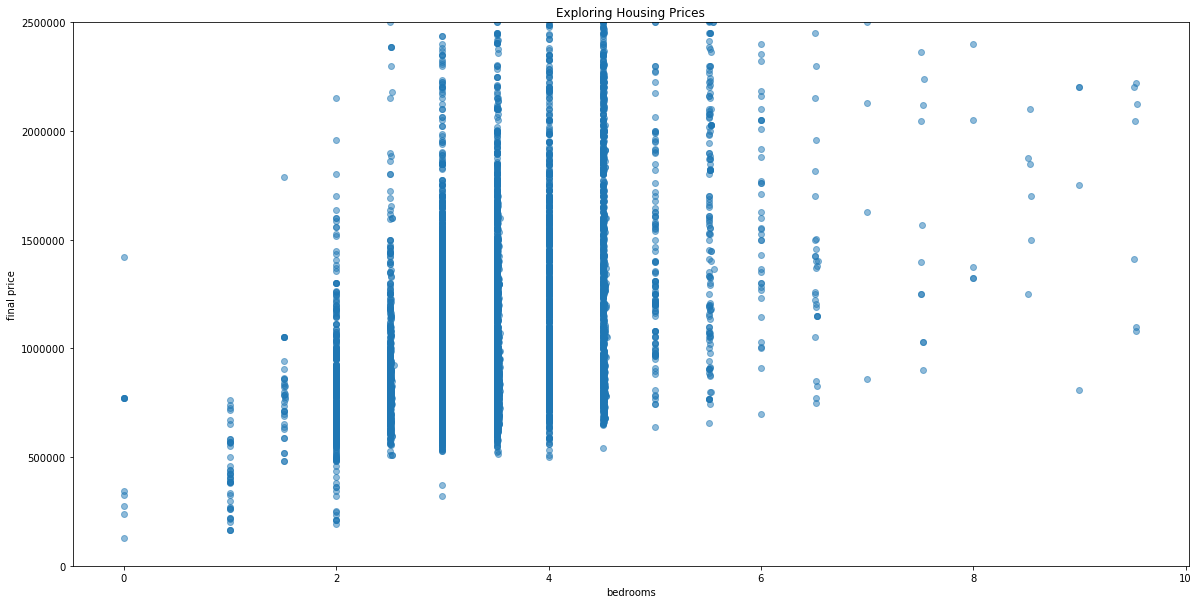

In [95]:
plt.figure(figsize=(20,10))
plt.scatter(houses.bedrooms, houses.final_price, alpha=0.5)
plt.title('Exploring Housing Prices')
plt.xlabel('bedrooms')
plt.ylabel('final price')
plt.ylim(0,2500000)
plt.show()

From 0 to 3 bedrooms, we notice an increasing linear-type relationship with the house price

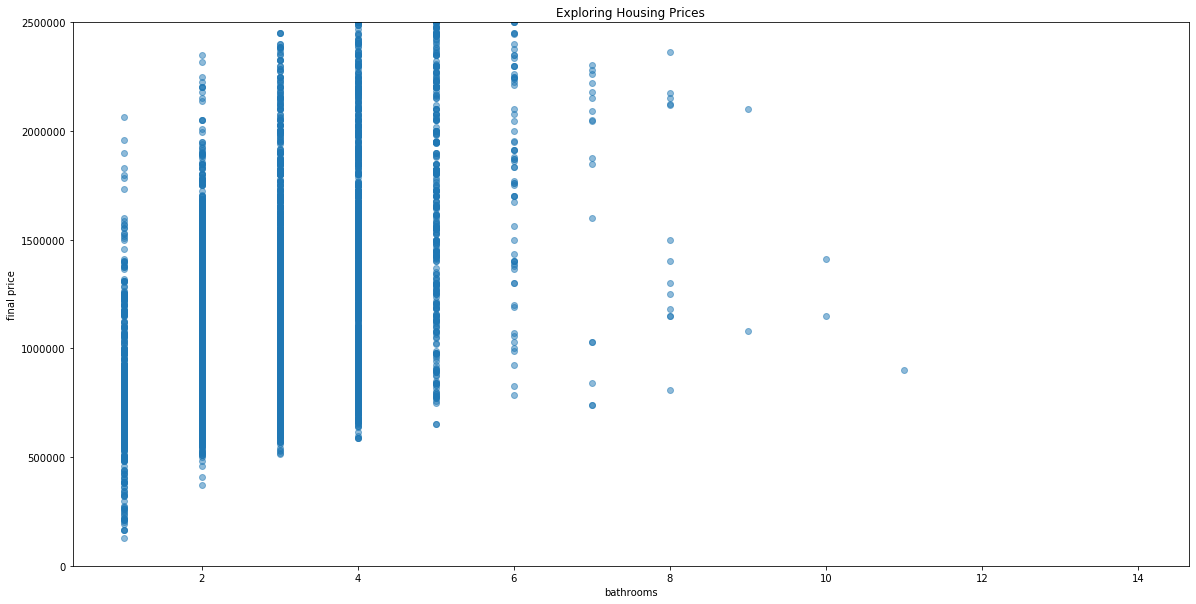

In [96]:
plt.figure(figsize=(20,10))
plt.scatter(houses.bathrooms, houses.final_price, alpha=0.5)
plt.title('Exploring Housing Prices')
plt.xlabel('bathrooms')
plt.ylabel('final price')
plt.ylim(0,2500000)
plt.show()

From 1 to 6 bathrooms, we notice an increasing linear-type relationship with the house price

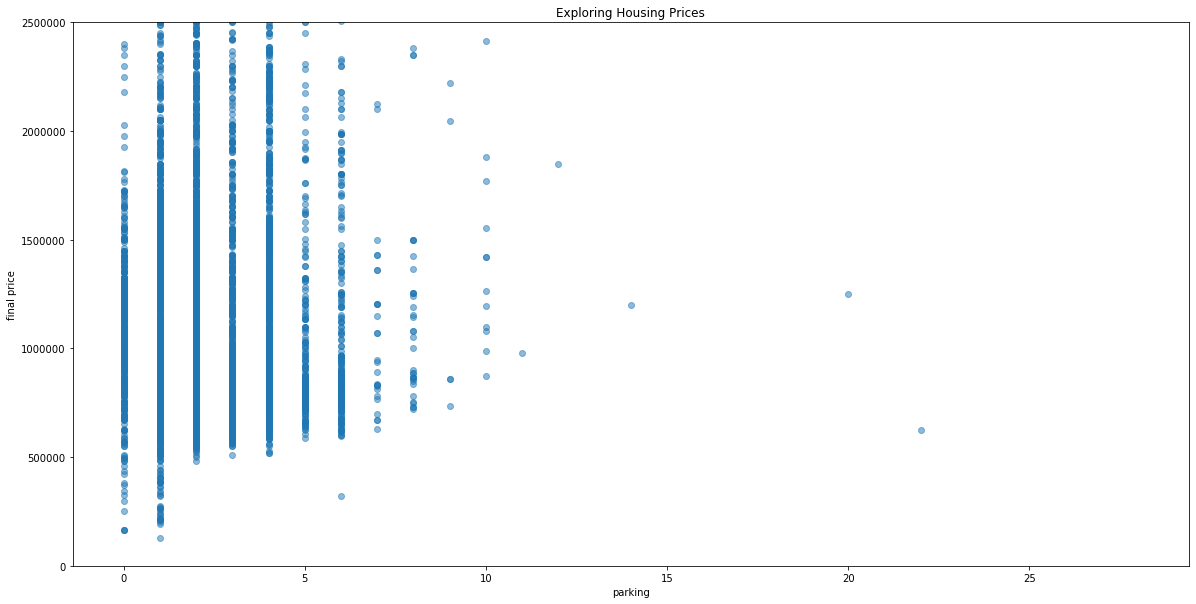

In [97]:
plt.figure(figsize=(20,10))
plt.scatter(houses.parking, houses.final_price, alpha=0.5)
plt.title('Exploring Housing Prices')
plt.xlabel('parking')
plt.ylabel('final price')
plt.ylim(0,2500000)
plt.show()

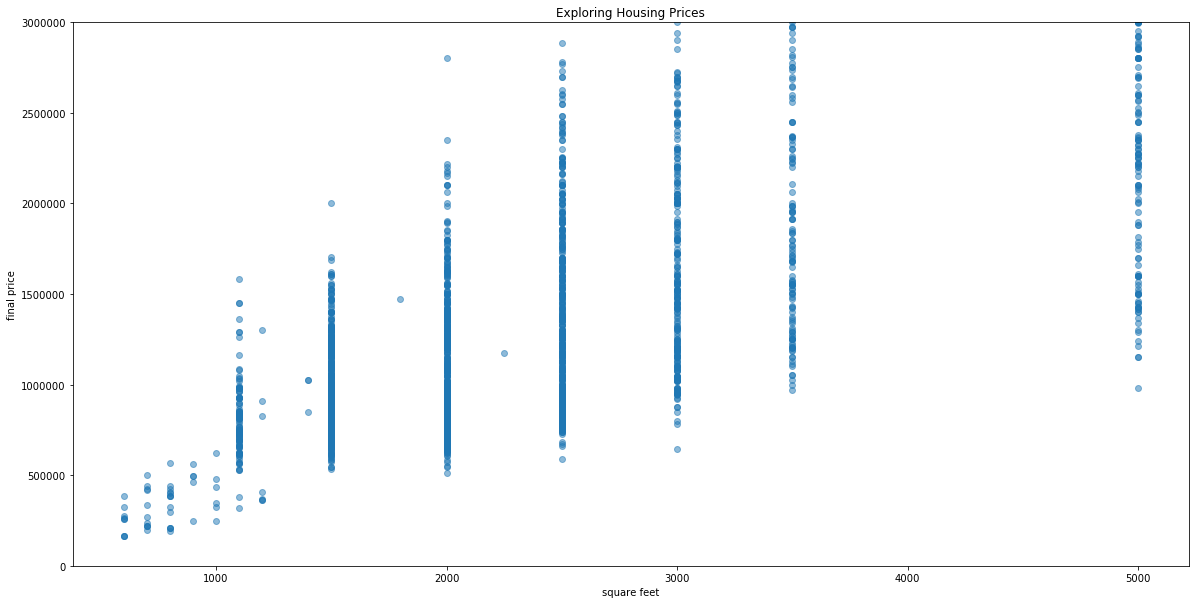

In [98]:
plt.figure(figsize=(20,10))
plt.scatter(houses.sqft, houses.final_price, alpha=0.5)
plt.title('Exploring Housing Prices')
plt.xlabel('square feet')
plt.ylabel('final price')
plt.ylim(0,3000000)
plt.show()

final_price    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

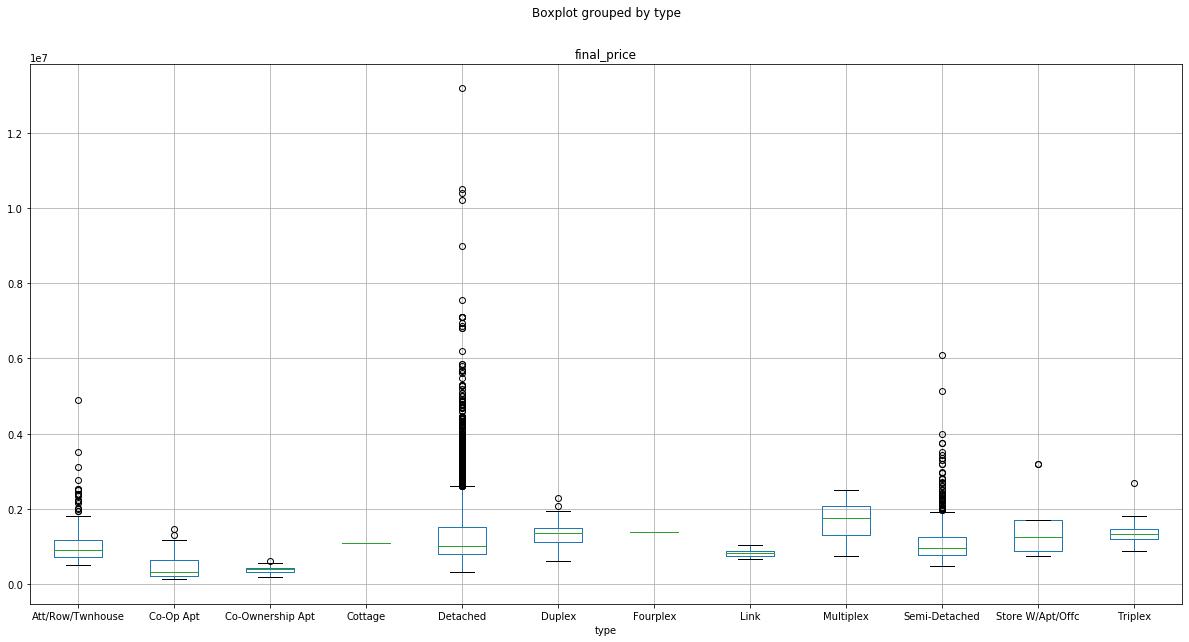

In [99]:
houses.boxplot(column='final_price', by='type', figsize=(20,10), return_type='axes')

In [26]:
# Use Geocode to get the house coordinates from the address
latitude=[]
longitude=[]
geolocator = Nominatim(user_agent="TO_explorer")
found=0
not_found=0

#for address in houses['full_address']:
for i in range (7000,7365):
    address = houses['full_address'].iloc[i]
    location = geolocator.geocode('{}, Ontario'.format(address), timeout=1)
    if(location is None):
        latitude.append('0')
        longitude.append('0')
        not_found+=1
        if not_found%10==0:
            print('{} postal codes were not found'.format(not_found))
        if not_found > 500:
            break
    else:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
        found+=1
        if found%10==0:
            print('{} postal codes were found'.format(found))
        
print('{} postal codes were found, while {} postal codes were not found'.format(found, not_found))

10 postal codes were found
20 postal codes were found
30 postal codes were found
40 postal codes were found
50 postal codes were found
60 postal codes were found
70 postal codes were found
80 postal codes were found
90 postal codes were found
100 postal codes were found
110 postal codes were found
120 postal codes were found
130 postal codes were found
140 postal codes were found
150 postal codes were found
160 postal codes were found
170 postal codes were found
180 postal codes were found
190 postal codes were found
200 postal codes were found
210 postal codes were found
220 postal codes were found
230 postal codes were found
240 postal codes were found
250 postal codes were found
260 postal codes were found
270 postal codes were found
280 postal codes were found
290 postal codes were found
300 postal codes were found
310 postal codes were found
320 postal codes were found
330 postal codes were found
340 postal codes were found
350 postal codes were found
359 postal codes were found, 

In [31]:
for i in range (7000,7365):
    houses['lat'].iloc[i]=latitude[i-7000]
    houses['long'].iloc[i]=longitude[i-7000]

In [32]:
houses.tail()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
7360,1222500.0,1298000.0,3.51,3.0,N/A sq. ft.,6.0,Detached,"334 Waterloo Ave, Toronto",43.7547,-79.4629,NaN
7361,1050000.0,1098000.0,5.52,4.0,N/A sq. ft.,4.0,Detached,"27 Harfleur Rd, Toronto",43.7932,-79.3001,NaN
7362,1025000.0,998888.0,5.00,5.0,3000–3500 sq. ft.,2.0,Detached,"179 Raleigh Ave, Toronto",43.7064,-79.2628,NaN
7363,681000.0,650000.0,3.00,3.0,N/A sq. ft.,1.0,Att/Row/Twnhouse,"68 Stagecoach Cir, Toronto",43.7881,-79.1605,NaN
7364,530000.0,530000.0,2.51,2.0,N/A sq. ft.,4.0,Detached,"43 Kalmar Ave, Toronto",43.6912,-79.2684,NaN


In [33]:
#Save lat & long data to new CSV file
houses.to_csv('data-coordinates-part3.csv')

Since I performed the coordinates search in 3 steps, I have to concatenate the 3 data files now

In [36]:
df1=pd.read_csv('data-coordinates-part1.csv',index_col=0)

In [39]:
df2=pd.read_csv('data-coordinates-part2.csv',index_col=0)

In [40]:
df3=pd.read_csv('data-coordinates-part3.csv',index_col=0)

In [41]:
for i in range (0,1000):
    df2['lat'].iloc[i]=df1['lat'].iloc[i]
    df2['long'].iloc[i]=df1['long'].iloc[i]

In [44]:
for i in range (7000,7365):
    df2['lat'].iloc[i]=df3['lat'].iloc[i]
    df2['long'].iloc[i]=df3['long'].iloc[i]

In [45]:
houses=df2
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
0,885000.0,898000.0,3.00,2.0,N/A sq. ft.,6.0,Semi-Detached,"2 Cabot Crt, Toronto",43.647028,-79.531004,NaN
1,825513.0,839000.0,2.00,2.0,N/A sq. ft.,1.0,Detached,"61 Twelfth St, Toronto",43.596934,-79.509620,NaN
2,2700000.0,2798000.0,4.00,5.0,2500–3000 sq. ft.,2.0,Detached,"110 Albertus Ave, Toronto",43.713951,-79.403311,NaN
3,975000.0,954900.0,2.00,2.0,1100–1500 sq. ft.,1.0,Duplex,"182 Broadway Ave, Toronto",43.711466,-79.390165,NaN
4,1057000.0,1079000.0,3.51,2.0,N/A sq. ft.,1.0,Semi-Detached,"342 Indian Road Cres, Toronto",43.664533,-79.461348,NaN


In [46]:
houses.tail()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long,city_district
7360,1222500.0,1298000.0,3.51,3.0,N/A sq. ft.,6.0,Detached,"334 Waterloo Ave, Toronto",43.754748,-79.462922,NaN
7361,1050000.0,1098000.0,5.52,4.0,N/A sq. ft.,4.0,Detached,"27 Harfleur Rd, Toronto",43.793183,-79.300133,NaN
7362,1025000.0,998888.0,5.00,5.0,3000–3500 sq. ft.,2.0,Detached,"179 Raleigh Ave, Toronto",43.706356,-79.262838,NaN
7363,681000.0,650000.0,3.00,3.0,N/A sq. ft.,1.0,Att/Row/Twnhouse,"68 Stagecoach Cir, Toronto",43.788142,-79.160543,NaN
7364,530000.0,530000.0,2.51,2.0,N/A sq. ft.,4.0,Detached,"43 Kalmar Ave, Toronto",43.691235,-79.268432,NaN


In [50]:
#remove lat & long coordinates that weren't found (they were set to 0)
index_ll = houses['lat']!=0

In [51]:
index_ll.value_counts()

True     7217
False     148
Name: lat, dtype: int64

In [52]:
houses=houses[index_ll]
houses.reset_index(drop=True, inplace=True)
houses.shape

(7217, 11)

In [ ]:
#Save lat & long data to new CSV file
houses.to_csv('data-coordinates-full.csv')

In [3]:
houses=pd.read_csv('data-coordinates-full.csv',index_col=0)

In [4]:
houses.groupby('type').count()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,full_address,lat,long,city_district
type,,,,,,,,,,
Att/Row/Twnhouse,534,534,534,534,534,534,534,534,534,0
Co-Op Apt,32,32,32,32,32,32,32,32,32,0
Co-Ownership Apt,30,30,30,30,30,30,30,30,30,0
Cottage,1,1,1,1,1,1,1,1,1,0
Detached,5015,5015,5015,5015,5015,5015,5015,5015,5015,0
Duplex,33,33,33,33,33,33,33,33,33,0
Fourplex,1,1,1,1,1,1,1,1,1,0
Link,41,41,41,41,41,41,41,41,41,0
Multiplex,22,22,22,22,22,22,22,22,22,0


Let's focus only on townhouses, semi-detached, and detached houses

In [5]:
index_type1 = houses['type'].str.contains('Twnhouse')
index_type2 = houses['type'].str.contains('Detached')

In [6]:
index_type = index_type1 | index_type2
index_type.value_counts()

True     7172
False     193
Name: type, dtype: int64

In [7]:
# Remove all other house types from the dataframe
houses=houses[index_type]
houses.reset_index(drop=True, inplace=True)
houses.shape

(7172, 11)

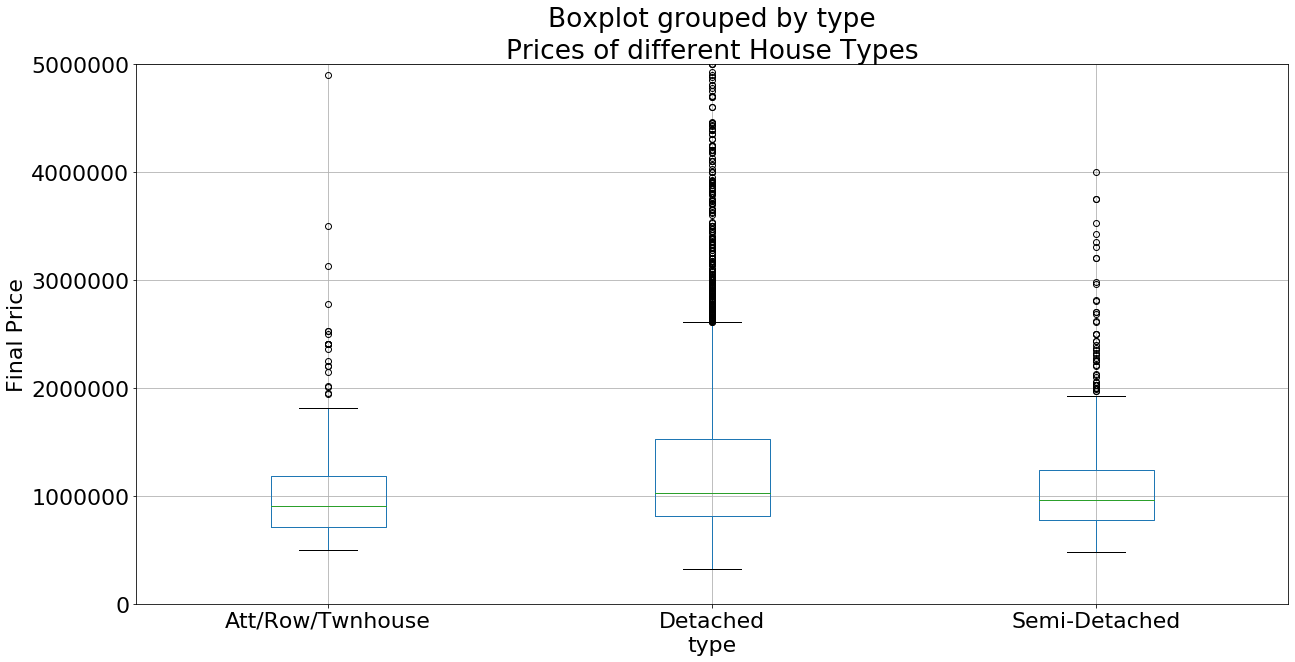

In [17]:
houses.boxplot(column='final_price', by='type', figsize=(20,10), return_type='axes')
plt.ylabel('Final Price')
plt.ylim(0,5000000)
plt.title('Prices of different House Types')
plt.rcParams.update({'font.size': 22})

We notice from the boxplot that houses above 2.5M are considered as outliers

Text(0, 0.5, 'final house price')

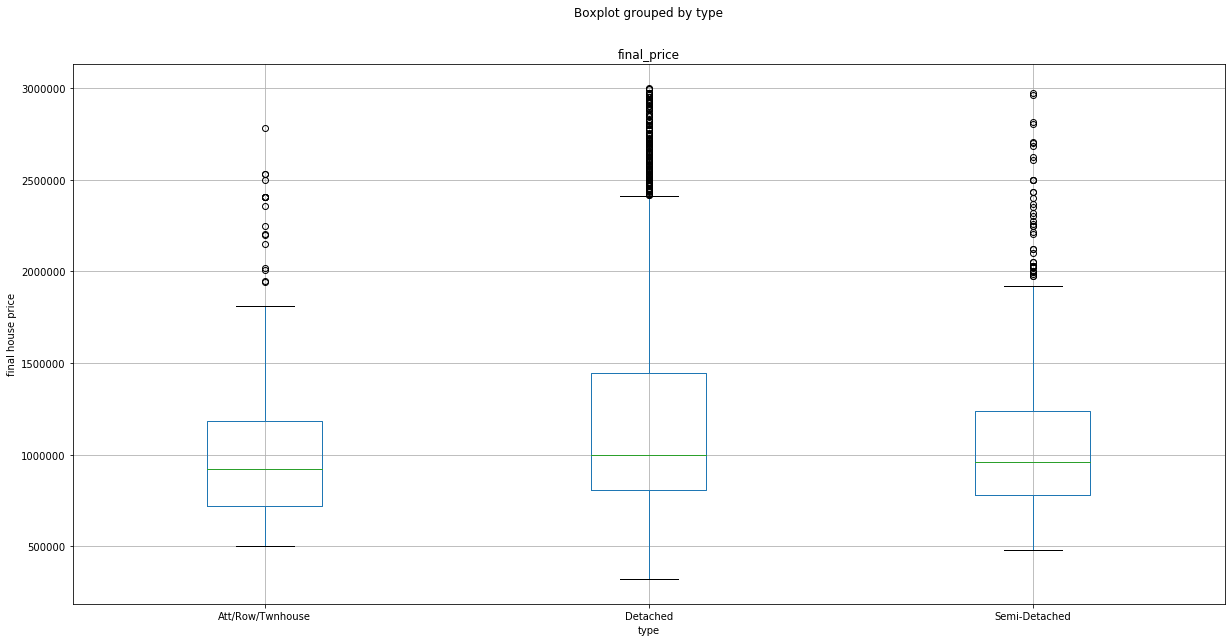

In [128]:
df_temp=houses[houses['final_price']<3000000]
df_temp.boxplot(column='final_price', by='type', figsize=(20,10), return_type='axes')
plt.ylabel('final house price')

From the boxplots, we can see that the values of townhouses & semi-detached houses are similar whereas the value of a detached house for the top quartiles is higher

In [113]:
#One hot encoding for Type
#houses['Detached']=(df2['type']=='Detached').astype('int')
#houses['Semi-Detached']=(df2['type']=='Semi-Detached').astype('int')
#houses['Twnhouse']=df2['type'].str.contains('Twnhouse').astype('int')

In [114]:
#Change type column from categorical to integer values
houses['type']=houses.type.astype('str').str.replace('Att/Row/Twnhouse','1')
houses['type']=houses.type.astype('str').str.replace('Semi-Detached','2')
houses['type']=houses.type.astype('str').str.replace('Detached','3')

In [115]:
houses.drop(['city_district'],axis=1,inplace=True)
houses.head()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,type,full_address,lat,long
0,885000.0,898000.0,3.00,2.0,NaN,6.0,2,"2 Cabot Crt, Toronto",43.647028,-79.531004
1,825513.0,839000.0,2.00,2.0,NaN,1.0,3,"61 Twelfth St, Toronto",43.596934,-79.509620
2,2700000.0,2798000.0,4.00,5.0,3000.0,2.0,3,"110 Albertus Ave, Toronto",43.713951,-79.403311
3,1057000.0,1079000.0,3.51,2.0,NaN,1.0,2,"342 Indian Road Cres, Toronto",43.664533,-79.461348
4,1530000.0,1399900.0,4.52,5.0,3500.0,4.0,3,"77 Inniswood Dr, Toronto",43.739059,-79.303981


In [116]:
houses.groupby('type').count()

,final_price,list_price,bedrooms,bathrooms,sqft,parking,full_address,lat,long
type,,,,,,,,,
1,522,522,522,522,170,522,522,522,522
2,1592,1592,1592,1592,474,1592,1592,1592,1592
3,4911,4911,4911,4911,1444,4911,4911,4911,4911


In [118]:
houses['type']=houses['type'].astype('int')
houses.dtypes

final_price     float64
list_price      float64
bedrooms        float64
bathrooms       float64
sqft            float64
parking         float64
type              int64
full_address     object
lat             float64
long            float64
dtype: object

In [119]:
#let's check again how much sqft data is missing
index_sqft = houses['sqft'].isna()
index_sqft.value_counts()

True     4937
False    2088
Name: sqft, dtype: int64

In [120]:
houses.to_csv('data-coordinates-final.csv')

Now our dataset is cleaned and ready for further analysis. **See the Part 2 Notebook.**